In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = 784
hidden_size = 512
num_classes = 10
num_epochs = 40
batch_size = 64
learning_rate = 0.001

### MNIST dataset 정의하기

In [2]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

### 정해진 조건(batch_size, transform, shuffle등등)으로 데이터를 공급할수 있는 dataloader 정의하기

In [3]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

### 2-Layer linear 모델 정의하기

In [4]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

### model parameter(weight, bias) 확인하기
- nn.Linear함수는 default로 bias가 True로 되어 있어 [output_dim, input_dim], [output_dim] 2개 array의 파라미터를 가지고 있다.
- nn.Linear 매개변수로 bias를 False로 하면 [output_dim, input_dim] array 1개의 파라미터만 생성된다.

#### bias가 True 일때

In [5]:
params = list(model.parameters())

print(f'bias True 일때 parameter array 총 개수:{len(params)}')
for i in range(len(params)):
    print(f'parameter array shape: {params[i].shape}')

bias True 일때 parameter array 총 개수:4
parameter array shape: torch.Size([512, 784])
parameter array shape: torch.Size([512])
parameter array shape: torch.Size([10, 512])
parameter array shape: torch.Size([10])


#### bias가 False 일때

In [6]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias=False) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, num_classes, bias=False)  
        
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(self.fc3(out))
        out = self.fc4(out)
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

In [7]:
params = list(model.parameters())

print(f'bias True 일때 parameter array 총 개수:{len(params)}')
for i in range(len(params)):
    print(f'parameter array shape: {params[i].shape}')

bias True 일때 parameter array 총 개수:6
parameter array shape: torch.Size([512, 784])
parameter array shape: torch.Size([512, 512])
parameter array shape: torch.Size([512])
parameter array shape: torch.Size([512, 512])
parameter array shape: torch.Size([512])
parameter array shape: torch.Size([10, 512])


### Loss값 및 gradient값 확인하기

In [8]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## backpropagation전 후 weight 값 확인하기

In [9]:
params[0].grad

In [10]:
for i, (images, labels) in enumerate(train_loader):
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)

    output = model(images)
    loss = criterion(output, labels)
    
    print('================================================')
    optimizer.zero_grad()
    
    zero_grad_list = []
    params = list(model.parameters())
    print(f'zero_grad:')
    for i in range(len(params)):
        #print(f'    grad {params[i].grad.mean()}')
        print(f'    weight {params[i].mean().detach().item()}')
    print('----------------------------------------------')
    
    loss.backward()#역전파 시행
    backward_list = []
    params = list(model.parameters())
    print(f'backward:')
    for i in range(len(params)):
        print(f'    grad {params[i].grad.mean()}')
        print(f'    weight {params[i].mean().detach().item()}')
    print('----------------------------------------------') #여기까지는 gradient만 계산했어
    
    optimizer.step() # gradient descent weight 업데이트가된다
    step_list = []
    params = list(model.parameters())
    print(f'gradient step:')
    for i in range(len(params)):
        print(f'    grad {params[i].grad.mean()}')
        print(f'    weight {params[i].mean().detach().item()}')
    print('================================================')
    print()
    
    break
    

    #print(loss.item())

zero_grad:
    weight -0.00013512547593563795
    weight 4.483810334932059e-05
    weight -0.0005264318897388875
    weight -2.2929078113520518e-05
    weight 0.003187894355505705
    weight -0.00019319615967106074
----------------------------------------------
backward:
    grad 2.2490085029858164e-06
    weight -0.00013512547593563795
    grad 2.5413708044652594e-06
    weight 4.483810334932059e-05
    grad 5.2988416427979246e-05
    weight -0.0005264318897388875
    grad -7.185371941886842e-08
    weight -2.2929078113520518e-05
    grad -5.787989357486367e-05
    weight 0.003187894355505705
    grad -3.996092519387151e-12
    weight -0.00019319615967106074
----------------------------------------------
gradient step:
    grad 2.2490085029858164e-06
    weight -0.00013512771693058312
    grad 2.5413708044652594e-06
    weight 4.483556404011324e-05
    grad 5.2988416427979246e-05
    weight -0.0005264850333333015
    grad -7.185371941886842e-08
    weight -2.2929010810912587e-05
    g

## 연결된 computation graph 타고 올라가기 

In [18]:
print(loss.grad_fn)
print(loss.grad_fn.next_functions[0][0])
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])
print(loss.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0])
print(loss.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions[0][0])
print(loss.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions[0][0])

IndexError: tuple index out of range

In [19]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

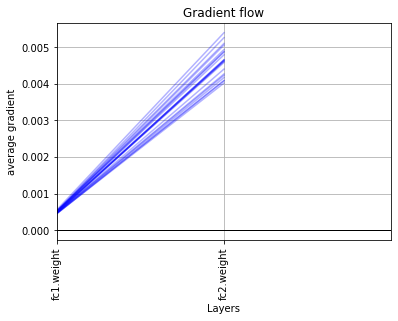

In [20]:
for i, (images, labels) in enumerate(train_loader):
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)

    output = model(images)
    loss = criterion(output, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    plot_grad_flow(model.named_parameters())
    
    #print(loss.item())
    if i == 20:
        break